## Helpers

In [260]:
import pandas as pd
import numpy as np
import time

In [261]:
def make_observations(df, size: int, future: int, step: int = 2):
    """
    Size is the number of candles used as a base for prophecy.
    Future=n sets as y the n-th price value since last know price.
    """
    assert future >0, 'Future must be >= 1'
    assert df.shape[0] >= size+future+1, 'Not efficient number of records'
    assert future < size, 'Well, keep future lower than size'
    # determine how many records
    imput_thr = int(np.floor(df.shape[0]/(size+1)))
    df = df.iloc[:(size+1)*imput_thr, :] 
    
    output = []
    n = df.shape[0]-(size+future+1)
    for i in range(int(n/step)):
        arr = df.iloc[step*i:step*i+size+future, :][['close', 'high', 'low', 'open', 'volume']]
        x, M, m = normalize_price(arr.iloc[:-future,:])
        y = (arr.close.values[-1] - m)/(M-m)
        output.append([x, y, M, m])
    
    df = pd.DataFrame(output, columns=['x', 'y', 'M', 'm'])
    return df
    

def normalize_price(arr):
    M = np.max(arr.high.values)
    m = np.min(arr.low.values)
    d = M - m
    output = (arr.iloc[:,:-1].values - m)/d 
    
    v = arr.volume.values
    v = (v - np.min(v))/(np.max(v) - np.min(v))
    output = [np.concatenate([o, [x]]) for o, x in zip(output, v)]
    return np.array(output), M , m

def reverse_norm(arr: np.array, M, m):
    d = M-m
    arr = d * arr + m
    return arr

                

## Import data

# Data from influx

In [65]:
from influxdb import InfluxDBClient
influx = InfluxDBClient('0.0.0.0', 5002, 'root', 'root', 'pairs')

In [277]:
size, future, step = 64, 2, 1
dfs = []

for p in ['ETHUSD']:
    for tf in ['1h', '3h', '6h']:
    #     for s in [True, False]:
        df = pd.read_pickle(f'data/{p}:{tf}_full.pkl')
        df = df.sort_values(by="tstmp")
        df = make_observations(df, size, future, step)
        dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df.to_pickle(f'data/ETH_s:{size}:f{future}:s{step}_vol.pkl')

## Models

In [33]:
from sklearn.model_selection import train_test_split

In [278]:
# x = df[['x', 'v']]
X_train, X_test, y_train, y_test = train_test_split(df.x.values, df.y.values, test_size=0.2, random_state=42)
X_train_p = np.array([x for x in X_train])
# X_train_v = np.array([x for x in X_train.v])
X_test_p = np.array([x for x in X_test])
# X_test_v = np.array([x for x in X_test.v])
# X_test = np.array([x for x in X_test])
X_test_p[0]

array([[0.93111693, 0.93935374, 0.92608737, 0.93767722, 0.15095192],
       [0.00341135, 0.0070268 , 0.00297035, 0.00633068, 0.23879309],
       [0.96894795, 0.97284768, 0.92382771, 0.93111693, 0.35037262],
       [0.00728192, 0.01278528, 0.        , 0.00338584, 1.        ],
       [0.94904839, 0.97284768, 0.94358148, 0.96716209, 0.1476168 ],
       [0.00968008, 0.01361261, 0.00720903, 0.00728192, 0.33289783],
       [0.00884911, 0.01361261, 0.00549607, 0.00728192, 0.99371237],
       [0.00959625, 0.01361261, 0.00549607, 0.00728192, 0.65906431],
       [0.00677897, 0.00965092, 0.00549607, 0.00950878, 0.18662737],
       [0.95116227, 0.95954486, 0.94507577, 0.94919418, 0.079945  ],
       [0.97302991, 0.97302991, 0.94970442, 0.95218276, 0.12467625],
       [0.00959625, 0.01049647, 0.00596987, 0.00705596, 0.10039812],
       [0.00830241, 0.01012107, 0.00775572, 0.00974568, 0.05595709],
       [0.96165873, 0.97485221, 0.96118493, 0.97302991, 0.10556174],
       [0.00884911, 0.01037984, 0.

In [78]:
# r = influx.query(f'SELECT * FROM USD{p} ORDER BY time ASC;', epoch='s')
# df = pd.DataFrame(list(r.get_points(measurement=f'BTCUSD{p}')))
# val = make_observations(val.iloc[:, :4], size, future)
# val.head()

,x,y,M,m
0,"[[0.2607886904761901, 0.31752232142857084, 0.2...",0.805060,8.0576,7.5200
1,"[[0.3056609500682954, 0.31446349977234866, 0.1...",0.440583,8.4591,7.8002
2,"[[0.35602704593145146, 0.36721846584285356, 0....",0.186291,8.6488,7.7910
3,"[[0.7675679863639882, 0.875184008677461, 0.752...",0.058461,8.4410,7.1503
4,"[[0.32516194589101943, 0.5175917693382448, 0.2...",0.997968,7.7075,6.9202


In [79]:
X_test = val.x.values
y_test = val.y.values
X_test = np.array([x for x in X_test])
X_test.shape

(766, 20, 4)

In [279]:
from keras.models import Model
from keras.layers import Dense, Embedding, Dropout, Activation, Concatenate, Input, LSTM, CuDNNLSTM, concatenate, Reshape, TimeDistributed
from livelossplot.keras import PlotLossesCallback
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from matplotlib import pyplot as plt

def score(y, y_hat):
    return {'mse': float(mean_squared_error(y, y_hat)),
    'mae': float(mean_absolute_error(y, y_hat)),
    'r2': float(r2_score(y, y_hat))}

def OHLC_prophecy(ts_input_shape,
                lstm_size = 32,
                lstm_dropout = 0.0,
                loss='mean_squared_error',
                activation = 'linear',
                optimizer='sgd'):
    
    net_input = Input(shape=(ts_input_shape, 5))
    flow = LSTM(lstm_size)(net_input)    
    output = Dense(1, activation=activation)(flow)
    
    model = Model(inputs=[net_input], outputs=output)
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [282]:
model = OHLC_prophecy(ts_input_shape=X_train_p[0].shape[0], 
                    lstm_size=5,
                      lstm_dropout=0.0,
                      optimizer='adam',
                      activation='linear'
                   )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 64, 5)             0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 5)                 220       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 6         
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________


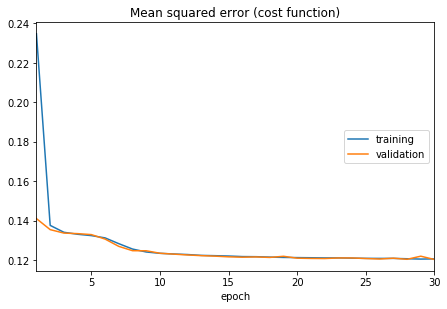

Mean squared error (cost function):
training   (min:    0.120, max:    0.235, cur:    0.121)
validation (min:    0.120, max:    0.141, cur:    0.120)


In [284]:
model.fit(
    X_train_p, y_train,
    epochs= 30,
    batch_size = 128,
    validation_data=(X_test_p, y_test),
    callbacks=[PlotLossesCallback(),
              EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10,)]
)

# model.fit(
#     [X_train_p, X_train_v], y_train,
#     epochs= 20,
#     batch_size = 64,
#     validation_data=([X_test_p, X_test_v], y_test),
#     callbacks=[PlotLossesCallback(), 
# #                TensorBoard(log_dir='/logs'),
#               EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10,)]
# )

In [283]:
filename = f'models/size{size}future{future}_130219.h5'
model.save(filename)
print(filename)

models/size64future2_130219.h5


{'mse': 87362.70662120142, 'mae': 164.32124276551406, 'r2': -0.4472538607787966}


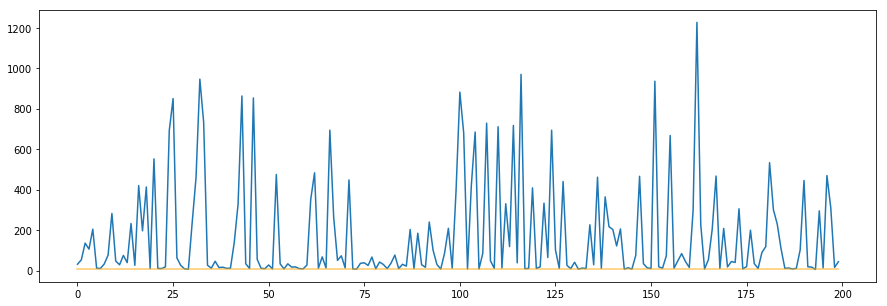

In [247]:
m = 200
y_hat = [model.predict([[x]])[0][0] for x in X_test_p[:m]]
y = y_test[:m]
print(score(y, y_hat))
plt.figure(figsize=(15,5))
plt.plot(y)
plt.plot(y_hat, color='orange', alpha=0.6)

## Plots / tests

In [1]:
from keras.models import load_model
model = load_model('models/size20future1_110219.h5')

Using TensorFlow backend.


In [7]:
int(model.input.shape[1])

20

In [175]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

class portfolio:
    def __init__(self, start_amount: float, model, fee=0.04):
        assert start_amount > 0, 'Want to play with no money?'
        self.start_amount = start_amount
        self.budget = start_amount  # dolars
        self.coins = 0
        self.fee = fee
        self.model = model
        self.history = []
        self.last_buy = 0

    def _process(self, window: pd.DataFrame):
        M = np.max(window.high.values)
        m = np.min(window.low.values)
        d = M - m
        output = (window.iloc[:,:-1] - m) / d
        vol = window.volume.values
        vol = (vol - np.min(vol))/(np.max(vol) - np.min(vol))
        assert output.shape[0] == vol.size, "Candles and volume sizes differ"
        output = np.array([np.concatenate([o, [x]]) for o, x in zip(output.values, vol)])
        
        return output, M, m

    def _reshape(self, window: pd.DataFrame, size):
        return window.values.reshape(size, 4)

    def _rescale(self, predicted_price, M, m):
        return (M - m) * predicted_price + m

    def _buy(self, price):
        self.coins = self.budget / price * (1 - self.fee)
        self.budget = 0
        self.last_buy = price

    def _sell(self, price):
        self.budget = self.coins * price * (1 - self.fee)
        self.coins = 0

    def _decide(self, price, prediction, epoch):
        if prediction >= price and self.coins == 0:
#             trade_cost = self.budget * self.fee
#             potential_profit = self.budget * (prediction - price)
#             if potential_profit > trade_cost:
            if (prediction/price - 1) > 0.01:
                self._buy(price)
                print(f'Epoch: {epoch} : BUY - actual: {price} predicted: {prediction}')
                self.history.append(('buy', price, prediction, self.coins, self.budget))

        if prediction < price and self.coins != 0:
#             trade_cost = self.coins * price * self.fee
#             potentail_loss = self.coins * (price - prediction)
#             if potentail_loss > trade_cost:
            if prediction < self.last_buy * 0.99:
                self._sell(price)
                print(f'Epoch: {epoch} : SELL - actual: {price} predicted: {prediction}')
                self.history.append(('sell', price, prediction, self.coins, self.budget))

    def simulate(self, df: pd.DataFrame):
        size = self.model.input_shape[1]
        # TODO: assert smth ! !
        y, y_hat = [], []
        self.epochs = df.shape[0] - size
        for i in range(self.epochs):
            window = df.iloc[i:i + size, :]
            recent_price = window.close.values[-1]
            output, M, m = self._process(window)
#             output = self._reshape(output, size)

            predicted_price = self.model.predict([[output]])[0][0]
            predicted_price = self._rescale(predicted_price, M, m)
            y.append(recent_price)
            y_hat.append(predicted_price)
            self._decide(recent_price, predicted_price, epoch=i)

        # make last trade
        if self.coins != 0:
            self._sell(recent_price)

        #  For plots
        self.y = y[1:]
        self.y_hat = y_hat

        self.summary()

    def summary(self):
        print('Portfolio summary')
        print(f'Transaction fee: {self.fee}')
        print(f'Start amount: {self.start_amount}')
        print(f'Final amount: {self.budget}')
        print(f'Earnings : {(self.budget - self.start_amount):.2f}')
        print(f'Profit : {100*(self.budget/self.start_amount -1):.2f}%')
        print(f'Decision points: {self.epochs}')
        print( f"Decisions made : {len(self.history)}, buy: {len([x for x in self.history if x[0]=='buy'])} sell: {len([x for x in self.history if x[0]=='sell'])}")

    def plot_history(self):
        coins = [x[3] for x in self.history if x[3] != 0]
        plt.plot(coins)
        plt.title('Coins history')
        plt.show()

        budget = [x[4] for x in self.history if x[4] != 0]
        plt.plot(budget)
        plt.title('Budget history')
        plt.show()

    def plot_prediction(self):
        plt.figure(figsize=(20,10))
        plt.plot(self.y)
        plt.plot(self.y_hat, color='orange')
        plt.show()
        
        

In [164]:
r = influx.query('SELECT * FROM LTCUSD1h ORDER BY time ASC;', epoch='s')
sample = pd.DataFrame(list(r.get_points(measurement='LTCUSD1h')))

,close,high,low,open,time,volume
0,86.690,86.868,86.164,86.164,1531976400,1607.988859
1,87.140,87.626,86.690,86.690,1531980000,5313.401498
2,86.340,87.245,86.251,87.041,1531983600,1627.098672
3,86.115,86.746,86.079,86.346,1531987200,2318.546876
4,87.643,87.858,86.086,86.144,1531990800,4207.205649


In [176]:
port = portfolio(1000, model, fee=0.004)

In [177]:
port.simulate(sample.iloc[:200,:][['close', 'open', 'high', 'low', 'volume']])

Epoch: 37 : BUY - actual: 82.101 predicted: 83.10841596829891
Portfolio summary
Transaction fee: 0.004
Start amount: 1000
Final amount: 997.4412102166842
Earnings : -2.56
Profit : -0.26%
Decision points: 148
Decisions made : 1, buy: 1 sell: 0


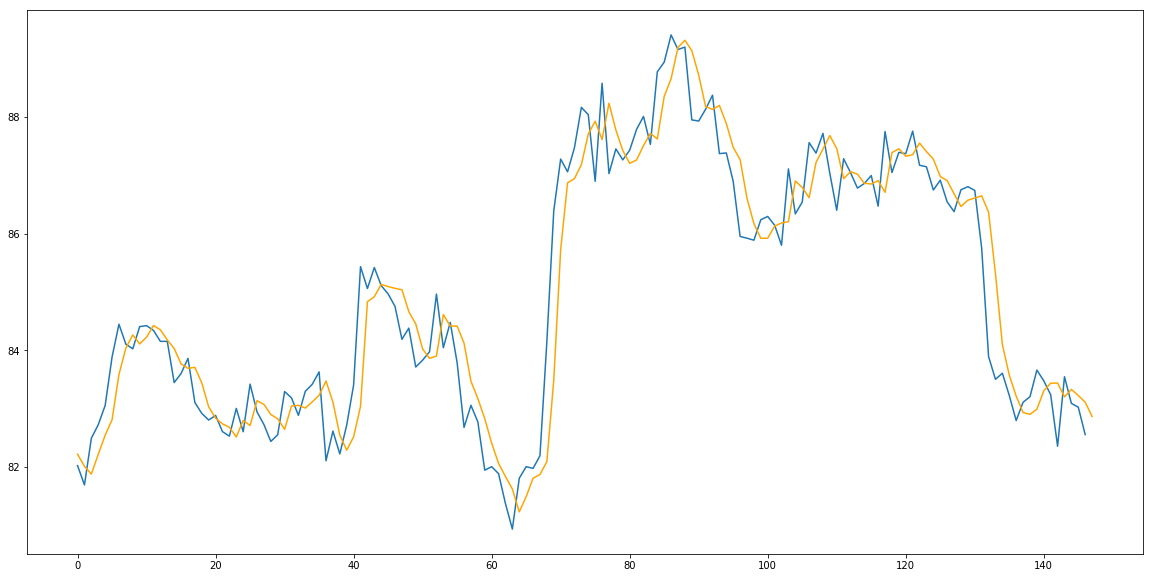

In [170]:
port.plot_prediction()

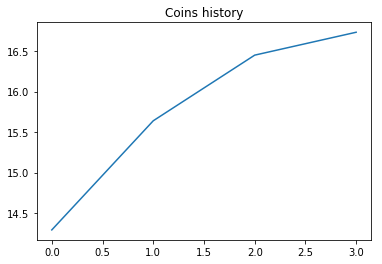

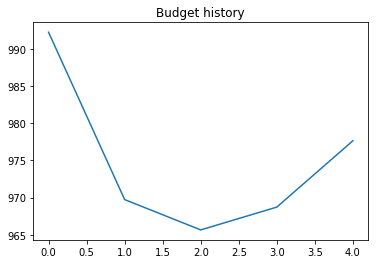

In [120]:
port.plot_history()